In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer
from nltk.tokenize import word_tokenize
import gensim
from gensim.models import word2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split

C:\Users\chase\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


This dataset contains the full episode scripts for the popular Seinfeld show.  It has features showing who spoke which line, who wrote the episode, and who directed the episode.  I hope to perform some NLP to glean some interesting insights and realationhips.

I aim to cluster around the writers of each episode.  Hopefully they will cluster naturally, I also want to see if I can create a supervised model that can predict the writer of an episode based on the dialogue.  

This data set is hosted on Kaggle, and was crawled from the http://www.seinology.com/ website.

In [2]:
raw_text_data = pd.read_csv('scripts.csv')
raw_director_data = pd.read_csv('episode_info.csv')

.shape and .head() show us that the raw_text_data DataFrame contains the script data and has 54,616 rows, each row being a single line of dialogue.  raw_director_data has 174 rows which has data showing episode Title, AirDate, Writers, and Director.  

In [3]:
raw_text_data.shape

(54616, 6)

In [4]:
raw_director_data.shape

(174, 8)

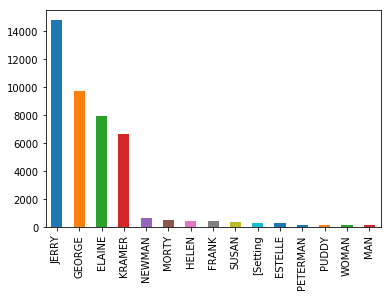

In [5]:
raw_text_data.Character.value_counts().head(15).plot(kind='bar')

In [6]:
raw_text_data.SEID.unique().shape

(173,)

Can see who has the most lines = [Setting is the tenth entry and that is not a person so definitely need to dig in and do some cleaning.  I want to get the dataframes into a more manageable dataframe as well.  

There are 173 episodes and I do not want to get below 100 episodes.  Mainly so I have enough corpus to deal with and its a nice number. Looking at this I would like to investigate the dialogue each writer and each character so I will try to balance it so ~10 writers are represented evenly as well.

In [7]:
raw_text_data[raw_text_data.Dialogue.isnull()]

,Unnamed: 0,Character,Dialogue,EpisodeNo,SEID,Season
13529,13529,** Pies - Just in case you did not know what t...,NaN,7.0,S04E07,4.0
14938,14938,"[On the bright side, Kramer and George arrive ...",NaN,12.0,S04E12,4.0
18353,18353,(The show begins. There are three different se...,NaN,24.0,S04E24,4.0
18354,18354,(Jerry's doing his stand-up routine at a comed...,NaN,24.0,S04E24,4.0
18355,18355,"We see the title 'Jerry', then, sitting at the...",NaN,24.0,S04E24,4.0
42939,42939,Definitions of several items in the Chicken Ro...,NaN,8.0,S08E08,8.0
45847,45847,HAL,NaN,18.0,S08E18,8.0
49651,49651,Notice,NaN,8.0,S09E08,9.0
50013,50013,The definition of Sari or Saree is,NaN,8.0,S09E08,9.0
53142,53142,MONTAGE,NaN,18.0,S09E18,9.0


The Character column at times does not have an actual character, need to clean this up as well.  The only nulls in both dataframes are ten nulls in the dialogue dataframe, of which only one is from an actual character so I will drop all of these.

In [8]:
raw_text_data.dropna(inplace=True)

In [9]:
#Removing ('word inside') brackets because that indicates actions not speech
pattern = r'\([^)]*\)'
raw_text_data['no_actions'] = [re.sub(pattern, '', i).lower() for i in raw_text_data['Dialogue']]

In [10]:
#Dropping [Setting.
raw_text_data[raw_text_data['Character'] == '[Setting'].shape
setting = raw_text_data[raw_text_data['Character'] == '[Setting']
raw_text_data = raw_text_data.drop(setting.index, axis=0)

Above we can see in line 2 that the text within the parentheses has been removed from 'no_actions' column.

In [11]:
#function to clean the raw data
def word_lister(word):
    #removing characters not a-z, A-Z, or 0-9
    A = [re.sub(r"[^a-zA-Z0-9]+", ' ', k) for k in word.split(" ")]
    A = [i.strip().lower() for i in A if i not in ' ']
    return A

In [54]:
#dictionary of common contractions and full text counterpart
contractions_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "does'nt": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he has",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it would",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
     "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she had / she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "tellin": 'telling',
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "thats": "that is",
      "there'd": "there would",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we would",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
     "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "ya": "you",
  "y'all": "you all",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had / you would",
  "you'd've": "you would have",
  "you'll": "you shall / you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have",
  '  ': ' ',
  '   ': ' '}
#function to correct the contractions
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(s, contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, s)

In [63]:
contractions_dict

{"ain't": 'am not',
 "aren't": 'are not',
 "can't": 'cannot',
 "can't've": 'cannot have',
 "'cause": 'because',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "does'nt": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he would',
 "he'd've": 'he would have',
 "he'll": 'he will',
 "he'll've": 'he will have',
 "he's": 'he has',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how is',
 "I'd": 'I would',
 "I'd've": 'I would have',
 "I'll": 'I will',
 "I'll've": 'I will have',
 "I'm": 'I am',
 "I've": 'I have',
 "isn't": 'is not',
 "it'd": 'it would',
 "it'd've": 'it would have',
 "it'll": 'it will',
 "it'll've": 'it will have',
 "it's": 'it is',
 "let's": 'let us',
 "ma'am": 'madam',
 "mayn't": 'may not',
 "might've": 'might have',
 "mightn't": 'might not',
 "mightn't've": 'might no

In [77]:

#function to clean text as identified throughout analysis
def clean_text(text):
    text = re.sub('…', '', text) # remove ellipses
    text = re.sub('♦', '', text) # remove diamonds
    return text

In [78]:
##applying functions to raw text
raw_text_data['cleaned_text'] = [ clean_text(_) for _ in raw_text_data['no_actions']]
raw_text_data['cleaned_text'] = [ expand_contractions(_) for _ in raw_text_data['cleaned_text']]


In [79]:
#applying function to the raw text
raw_text_data['cleaned_text'] = [word_lister(w) for w in raw_text_data['cleaned_text']]
#putting it into string form
raw_text_data['cleaned_text'] = [' '.join(word) for word in raw_text_data['cleaned_text']]


Now I will try to add the Writer column to the raw text column.  I can match the SEID for this.

In [80]:
# converting the SEID and Writers features from raw_director_data to array for easier manipulation
x = np.array(raw_director_data.loc[:, ['SEID', 'Writers']])

b=[]
for episode in raw_text_data['SEID']:
    a=[]
    for i in x:
        if episode == i[0]:
            a.append(i[1])
    b.append(a)
   

raw_text_data['Writers'] = b

In [81]:
# converting the SEID and Directors features from raw_director_data to array for easier manipulation
x = np.array(raw_director_data.loc[:, ['SEID', 'Director']])

b=[]
for episode in raw_text_data['SEID']:
    a=[]
    for i in x:
        if episode == i[0]:
            a.append(i[1])
    b.append(a)
   

raw_text_data['Director'] = b

Plotting Writers and Directors episode counts

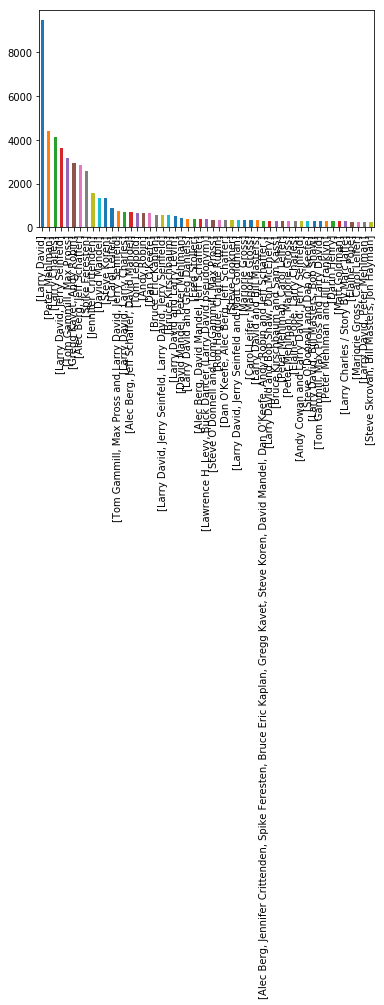

In [82]:
raw_text_data.Writers.value_counts().plot(kind='bar')

Looking at my graph of writers it appears very unbalanced.  The problem is that a lot of the writers are involved with so few written dialogue which will give my clustering algorithms trouble in identifying special characteristics of their writing.  It may also tank the model in general when it may have been OK at predicting other writers.  Because of this I will drop all but the most common 8 writers.  

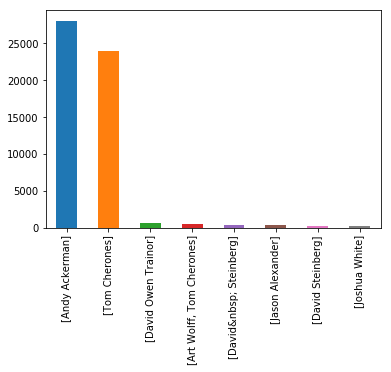

In [83]:
raw_text_data.Director.value_counts().head(15).plot(kind='bar')

With so few directors (save for the top two) involved in the dialogue, if we wanted to cluster around directors I would remove all but the top two from the model.  For now I am only concerned with the writers so I will aim to keep the top eight most common writers in my model;

In [271]:
df=raw_text_data.copy()
df.reindex()
df['Writer_string'] = [str(x) for x in df['Writers']]
df1 = df[df['Writer_string'] == '[\'Larry David\']']
df2 = df[df['Writer_string'] == '[\'Peter Mehlman\']']
df3 = df[df['Writer_string'] == '[\'Larry Charles\']']
df4 = df[df['Writer_string'] == '[\'Larry David, Jerry Seinfeld\']']
df5 = df[df['Writer_string'] == '[\'Tom Gammill, Max Pross\']']
df6 = df[df['Writer_string'] == '[\'Gregg Kavet, Andy Robin\']']
df7 = df[df['Writer_string'] == '[\'Alec Berg, Jeff Schaffer\']']
df8 = df[df['Writer_string'] == '[\'Spike Feresten\']']

top_writers_data = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8])

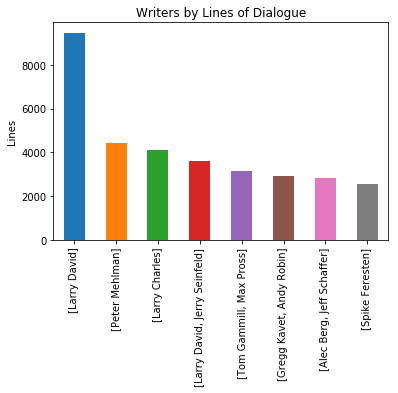

In [272]:
plt.figure()
plt.title('Writers by Lines of Dialogue')
plt.ylabel('Lines')
top_writers_data.Writers.value_counts().plot(kind='bar')


In [273]:
top_writers_data.shape

(33088, 11)

Now I'll generate a word cloud for each Writer to see how they compare:

In [277]:
from wordcloud import WordCloud, STOPWORDS

Looking at the first three writers they all use [know, i'm, well, like, oh, yeah, and get] a lot. I'll add these to the stopwords and try again:

These words showed very frequently in every wordcloud.  Because of this I'll remove them to try and get the clusters more unique.

In [279]:
stopwords = STOPWORDS.update(['know', 'i\'m', 'well', 'like', 'oh', 'yeah', 'get', 'got', 'think', 'hey', 'right',
                             'see', 'go', 'really', 'going', 'gonna', 'see', 're', 'll', 'don'])

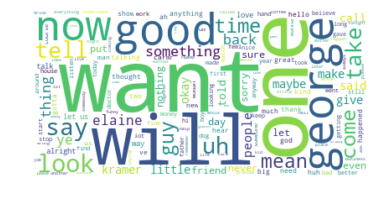

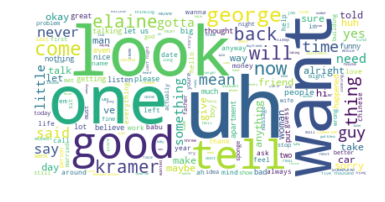

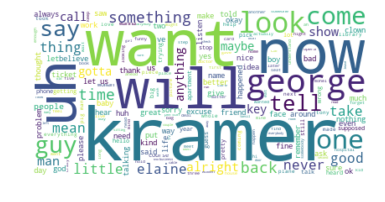

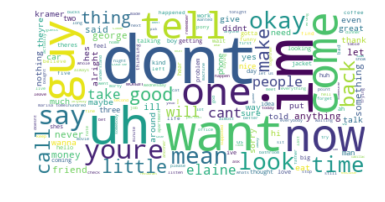

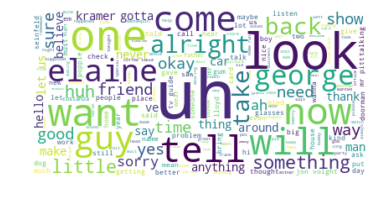

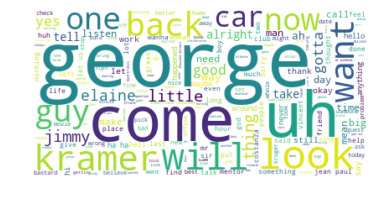

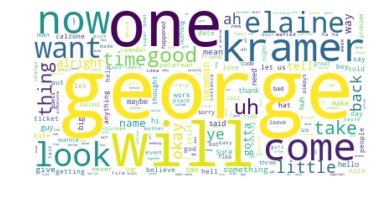

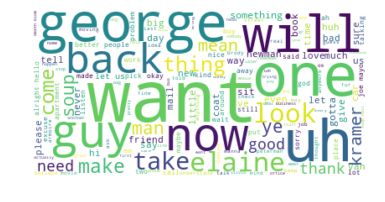

In [295]:
#Larry David word cloud
LD_cloud = " ".join(text for text in df1['cleaned_text'])
LD_cloud = WordCloud(stopwords=stopwords, background_color="white", relative_scaling=1).generate(LD_cloud)

plt.imshow(LD_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Peter Mehlman word cloud
PM_cloud = " ".join(text for text in df2['cleaned_text'])
PM_cloud = WordCloud(stopwords=stopwords, background_color="white", relative_scaling=1).generate(PM_cloud)

plt.imshow(PM_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Larry Charles word cloud
LC_cloud = " ".join(text for text in df3['cleaned_text'])
LC_cloud = WordCloud(stopwords=stopwords, background_color="white", relative_scaling=1).generate(LC_cloud)

plt.imshow(LC_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Larry David Jerry Seinfeld word cloud
LDJS_cloud = " ".join(text for text in df4['cleaned_text'])
LDJS_cloud = WordCloud(stopwords=stopwords, background_color="white", relative_scaling=1).generate(LDJS_cloud)

plt.imshow(LDJS_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Tommy Gammill Max Pross word cloud
TGMP_cloud = " ".join(text for text in df5['cleaned_text'])
TGMP_cloud = WordCloud(stopwords=stopwords, background_color="white", relative_scaling=1).generate(TGMP_cloud)

plt.imshow(TGMP_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Gregg Kavet Andy Robin word cloud
GKAR_cloud = " ".join(text for text in df6['cleaned_text'])
GKAR_cloud = WordCloud(stopwords=stopwords, background_color="white", relative_scaling=1).generate(GKAR_cloud)

plt.imshow(GKAR_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Alec Berg Jeff Schaffer word cloud
ABJS_cloud = " ".join(text for text in df7['cleaned_text'])
ABJS_cloud = WordCloud(stopwords=stopwords, background_color="white", relative_scaling=1).generate(ABJS_cloud)

plt.imshow(ABJS_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Spike Feresten word cloud
SF_cloud = " ".join(text for text in df8['cleaned_text'])
SF_cloud = WordCloud(stopwords=stopwords, background_color="white", relative_scaling=1).generate(SF_cloud)

plt.imshow(SF_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [102]:
# list of episode dialogue, [0] is episode1  [1] is epsisode 2 ... etc... for use later by spaCy...
episode_dialogue = np.asarray(top_writers_data['cleaned_text'].groupby(top_writers_data['SEID']).sum())

# Doc2Vec

In [104]:
# Parse the data. This can take some time.
nlp = spacy.load('en_core_web_sm')
episode_doc = [nlp(sent) for sent in episode_dialogue]
# getting tokens per episode by breaking the dialogue per episode down into sentences and then tokens ignoring punct and stop words
# updating Seinfeld specific stopwords:
nlp.Defaults.stop_words |= {'know', 'i\'m', 'well', 'like', 'oh', 'yeah', 'get', 'got', 'jerry', 'think', 'hey', 'right',
                             'see', 'go', 'really', 'going', 'gonna', 'see'}
episode_4_doc2vec=[]
for w in episode_doc:
    w = [
            token.lemma_.lower()
            for token in w
            if not token.is_stop
            and not token.is_punct
        ]
    episode_4_doc2vec.append(w)
    
       

In [138]:
#Running doc2vec on token list in episodes
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(episode_4_doc2vec)]
d2v= Doc2Vec(documents, vector_size=30, min_count=7, sample=.001, dm =1, workers=4, epochs=1000)

In [139]:
#Getting vectors for episode
doc_vectors = d2v.docvecs.vectors_docs
#putting in dataframe
d2v_df = pd.DataFrame(doc_vectors)

# getting episodes to each epsiode vector
SEID_sorted = top_writers_data.sort_values(by=['Unnamed: 0'])['SEID'].unique()

#putting into dataframe
d2v_df['Episode']=SEID_sorted

#getting writers to each episode vector
writers_sorted=[]
for x in d2v_df['Episode']:
    for i, w in enumerate(raw_director_data['SEID']):
        if x == w:
            writers_sorted.append(raw_director_data['Writers'].iloc[i])

#putting into dataframe
d2v_df['Writers']=writers_sorted
#putting text into dataframe
d2v_df['text'] = episode_dialogue

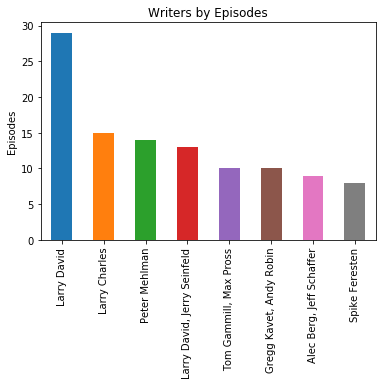

In [140]:
plt.figure()
plt.title('Writers by Episodes')
plt.ylabel('Episodes')
d2v_df.Writers.value_counts().plot(kind='bar')


## Setting up training data, reducing to two dimensions for graphing. Initializing K Means

In [182]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
#setting up training and testing data
X_train_w_text, X_test, Y_train, Y_test = train_test_split(d2v_df.drop(columns=['Writers']), d2v_df['Writers'], test_size=0.25)

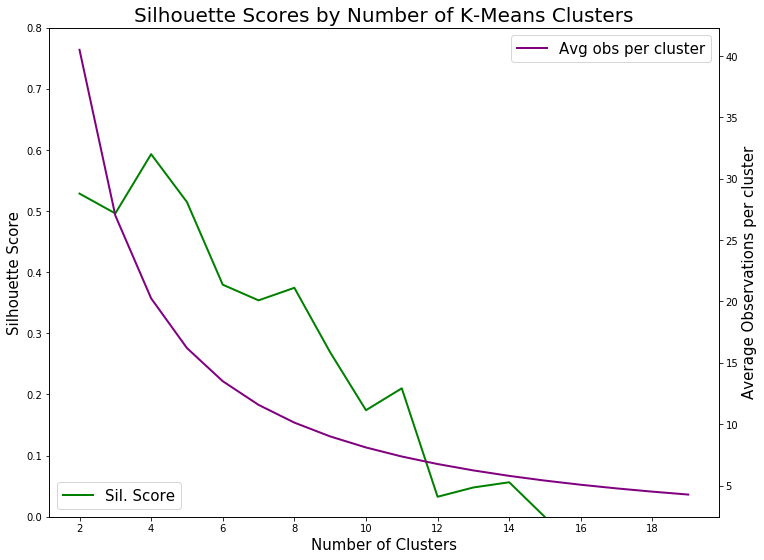

In [247]:
#Silhouette Scoreing is a decent proxy for knowing how
#many clusters to explore initially
from sklearn import cluster
from sklearn.metrics import silhouette_score

#Getting X_train without text data... doing this after split so I have text data with corresponding X_train group
X_train=X_train_w_text.drop(columns=['Episode', 'text'])

#training/clustering data
X_doc2vec_train = X_train

# Normalize the data.
X_doc2vec_norm = normalize(X_doc2vec_train)

#graphical data
X_doc2vec_graph = PCA(n_components=2).fit_transform(X_doc2vec_norm)

#graphical data
X_doc2vec_graph = PCA(n_components=2).fit_transform(X_doc2vec_norm)

fnclusts = list(range(2,20,1))
fsscores = [] 
avg_obs = []

for no in fnclusts:
    d2v_clusters = cluster.KMeans(n_clusters=no, random_state=42).fit_predict(X_doc2vec_graph)    
    fsscores.append(silhouette_score(X_doc2vec_graph, d2v_clusters, metric='cosine'))
    avg_obs.append(pd.value_counts(d2v_clusters).mean())


#Visualize Resultsa
fig, ax = fig, ax = plt.subplots(figsize=(12,9))
ax2 = ax.twinx()
ax = sns.lineplot(fnclusts, fsscores,color='g', label='Sil. Score', linewidth=2, ax=ax)
ax2 =sns.lineplot(fnclusts, avg_obs,color='purple',label='Avg obs per cluster', linewidth=2)
ax.set_ylabel('Silhouette Score',fontsize=15)
ax.set_xlabel('Number of Clusters',fontsize=15)
ax.legend(loc='lower left',fontsize=15)
ax2.legend(loc='upper right',fontsize=15)
plt.ylabel('Average Observations per cluster',fontsize=15)
plt.title('Silhouette Scores by Number of K-Means Clusters',fontsize=20)
ax.set_ylim([0,.80])
ax.set_xticks([2,4,6,8,10,12,14,16,18])
plt.show()

In [184]:
# 4 has high silhouette score before dropping off so will use 6 clusters

In [315]:
#training/clustering data
X_doc2vec_train = X_train.drop(columns=['text'])

# Normalize the data.
X_doc2vec_norm = normalize(X_doc2vec_train)

#graphical data
X_doc2vec_graph = PCA(n_components=2).fit_transform(X_doc2vec_norm)

# Calculate predicted values.
y_pred_Kmeans = KMeans(n_clusters=4, random_state=42).fit_predict(X_doc2vec_graph)



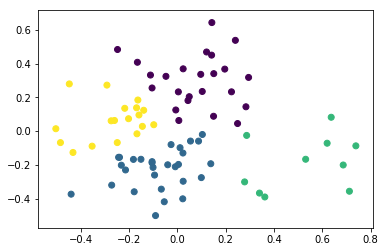

In [316]:
# Plot the solution.
plt.scatter(X_doc2vec_graph[:, 0], X_doc2vec_graph[:, 1], c=y_pred_Kmeans)
plt.show()

In [303]:
#Clustering evaluation

# Silhouette Score:
print(silhouette_score(X_doc2vec_graph, y_pred_Kmeans, metric='cosine'))

# Crosstab
print(pd.crosstab(y_pred_Kmeans, Y_train))

0.38871017119648665
Writers  Alec Berg, Jeff Schaffer  Gregg Kavet, Andy Robin  Larry Charles  \
row_0                                                                       
0                               0                        0              0   
1                               0                        1              4   
2                               2                        1              3   
3                               0                        0              2   
4                               0                        2              0   
5                               2                        1              1   
6                               1                        0              4   
7                               0                        0              0   

Writers  Larry David  Larry David, Jerry Seinfeld  Peter Mehlman  \
row_0                                                              
0                  2                            1              0   
1    

# Cosine similarity between Larry Charles and Larry David:
# May DELETE THIS AND BELOW 2 cells

In [284]:
david_data = d2v_df[d2v_df['Writers'] == 'Larry David'].drop(columns=['Episode', 'Writers', 'text'])
charles_data = d2v_df[d2v_df['Writers'] == 'Larry Charles'].drop(columns=['Episode', 'Writers', 'text'])
from sklearn.metrics.pairwise import cosine_similarity
cosine_sims = cosine_similarity(david_data, charles_data)

In [287]:
david_data.shape

(29, 30)

In [288]:
charles_data.shape

(15, 30)

In [290]:
cosine_sims[0]

array([-0.01830752,  0.33852592, -0.05981957, -0.02839985, -0.02539462,
       -0.04672841, -0.05626919,  0.05814525,  0.21180053, -0.08072989,
        0.15211561,  0.08441085,  0.1346381 ,  0.1067425 ,  0.15614977],
      dtype=float32)

## Initializing and graphing Spectral Clustering:

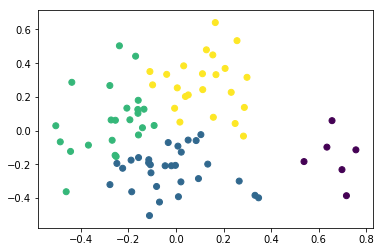

In [314]:
from sklearn.cluster import SpectralClustering

# Calculate predicted values.
y_pred_sc = SpectralClustering(n_clusters=4, random_state=42).fit_predict(X_doc2vec_graph)

# Plot the solution.
plt.scatter(X_doc2vec_graph[:, 0], X_doc2vec_graph[:, 1], c=y_pred_sc)
plt.show()

In [298]:
#Clustering evaluation

# Silhouette Score:
print(silhouette_score(X_doc2vec_graph, y_pred_sc, metric='cosine'))

# Crosstab
print(pd.crosstab(y_pred_sc, Y_train))

-0.1648550352427051
Writers  Alec Berg, Jeff Schaffer  Gregg Kavet, Andy Robin  Larry Charles  \
row_0                                                                       
0                               0                        0              1   
1                               0                        1              4   
2                               2                        1              1   
3                               0                        0              1   
4                               3                        1              6   
5                               0                        0              1   
6                               0                        0              0   
7                               0                        2              0   

Writers  Larry David  Larry David, Jerry Seinfeld  Peter Mehlman  \
row_0                                                              
0                  5                            1              2   
1    

## Initializing and graphing Affinity Propagation:

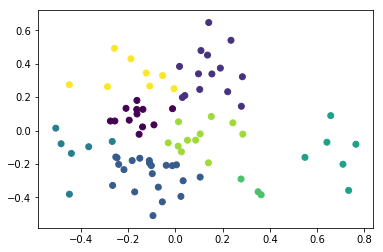

In [254]:
from sklearn.cluster import AffinityPropagation

# Calculate predicted values.
y_pred_ap = AffinityPropagation(damping=0.95, max_iter=1000, convergence_iter=100, ).fit_predict(X_doc2vec_graph)

# Plot the solution.
plt.scatter(X_doc2vec_graph[:, 0], X_doc2vec_graph[:, 1], c=y_pred_ap)
plt.show()

In [255]:
#Clustering evaluation

# Silhouette Score:
print(silhouette_score(X_doc2vec_graph, y_pred_ap, metric='cosine'))

# Crosstab
print(pd.crosstab(y_pred_ap, Y_train))

0.26302480506111986
Writers  Alec Berg, Jeff Schaffer  Gregg Kavet, Andy Robin  Larry Charles  \
row_0                                                                       
0                               0                        1              5   
1                               1                        0              4   
2                               1                        2              1   
3                               1                        1              0   
4                               0                        0              0   
5                               0                        0              0   
6                               2                        1              3   
7                               0                        0              1   

Writers  Larry David  Larry David, Jerry Seinfeld  Peter Mehlman  \
row_0                                                              
0                  4                            1              0   
1    

## Interpreting Clusters:

In [320]:
## Looking at crosstabs:
## 5 Jerry Seinfeld wrote episodes are the 5 point cluster off to the right of the rest of the clusters.  Each algorithm does a 
## good job of clustering Larry David/Jerry Seinfeld corwritten episodes together, however the rest of the clusters do not do a great job
## of clustering writers.  Here are some findings per algorithm:
## K-Means:
    ## cluster 2 does well at clustering Larry David written episodes
    ## cluster 3 good at clustering Larry David/Jerry Seinfeld co-written episodes
## Spectral Clustering:
    ## cluster 4 good at clustering Larry David/Jerry Seinfeld co-written episodes
    ## cluster 0 good at clustering Larry David written episodes
## Affinity Propagation:
    ## cluster 0 good at clustering Larry David/Jerry Seinfeld co-written episodes
## DBSCAN:
    ## clluster 0 good at clustering Larry David/Jerry Seinfeld co-written episodes

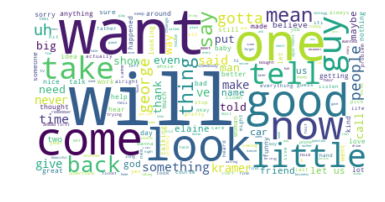

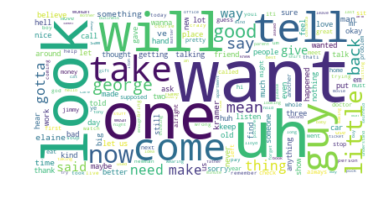

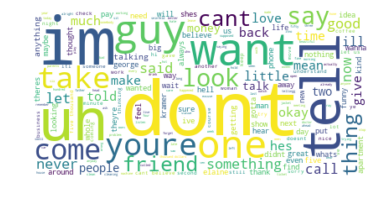

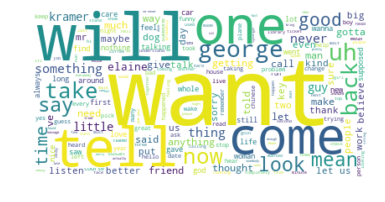

In [329]:
## Now I will run wordcloud on each cluster to explore how the algorithms may be clustering:
## Creating KMeans dataframe
KMeans_df = pd.DataFrame()
KMeans_df = X_train
KMeans_df['clusters'] = y_pred_Kmeans
KMeans_df['text'] = X_train_w_text['text']

## Creating word cloud for cluster 0 
KMeans_clust0_cloud = []
for x in KMeans_df[KMeans_df['clusters'] == 0]['text']:
        KMeans_clust0_cloud.append(x)
KMeans_clust0_cloud = " ".join(text for text in KMeans_clust0_cloud)
KMeans_clust0_cloud = WordCloud(stopwords=stopwords, background_color="white", relative_scaling=1).generate(KMeans_clust0_cloud)

plt.imshow(KMeans_clust0_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Creating word cloud for cluster 1
KMeans_clust1_cloud = []
for x in KMeans_df[KMeans_df['clusters'] == 1]['text']:
    KMeans_clust1_cloud.append(x)
KMeans_clust1_cloud = " ".join(text for text in KMeans_clust1_cloud)
KMeans_clust1_cloud = WordCloud(stopwords=stopwords, background_color="white", relative_scaling=1).generate(KMeans_clust1_cloud)

plt.imshow(KMeans_clust1_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Creating word cloud for cluster 2
KMeans_clust2_cloud = []
for x in KMeans_df[KMeans_df['clusters'] == 2]['text']:
    KMeans_clust2_cloud.append(x)
KMeans_clust2_cloud = " ".join(text for text in KMeans_clust2_cloud)
KMeans_clust2_cloud = WordCloud(stopwords=stopwords, background_color="white", relative_scaling=1).generate(KMeans_clust2_cloud)

plt.imshow(KMeans_clust2_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Creating word cloud for cluster 3
KMeans_clust3_cloud = []
for x in KMeans_df[KMeans_df['clusters'] == 3]['text']:
    KMeans_clust3_cloud.append(x)
KMeans_clust3_cloud = " ".join(text for text in KMeans_clust3_cloud)
KMeans_clust3_cloud = WordCloud(stopwords=stopwords, background_color="white", relative_scaling=1).generate(KMeans_clust3_cloud)

plt.imshow(KMeans_clust3_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## Random Forest Classifier

K Means Random Forest Test Group score without clusters: 0.18518518518518517


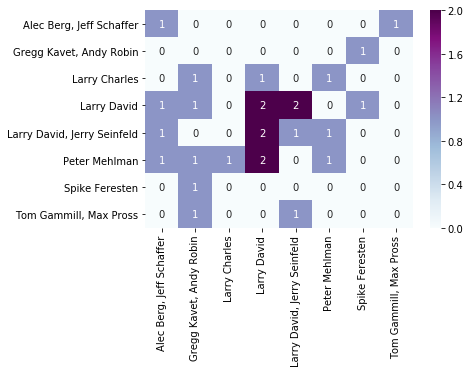

In [330]:
## To check if these clusters have predictive value, I'll plug them in as features in a supervised model.  First I'll try
## a random forest classifier and run the feature_importances function.  I will also run the model without the clusters to see
## if the model predicts better or worse.

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
## putting cluster into rfc_xtrain
rfc_xtrain = X_train.drop(columns=['clusters', 'text'])
rfc_xtrain['clusters'] = KMeans_df['clusters']
rfc.fit(rfc_xtrain, Y_train)

#rfc model without clusters
rfc2 = RandomForestClassifier()
rfc_xtrain_no_clust = X_train.drop(columns=['clusters', 'text'])
rfc2.fit(rfc_xtrain_no_clust, Y_train)

#plugging Test holdout group without clusters with confusion matrix
print('K Means Random Forest Test Group score without clusters:', rfc2.score(X_test.drop(columns=['Episode', 'text']), Y_test))


#confusion matrix
noclust = rfc2.predict(X_test.drop(columns=['Episode', 'text']))
from sklearn.metrics import confusion_matrix
confusion_matrix(noclust, Y_test)
testlabels = list(set(Y_test[:]))
testlabels = sorted(testlabels)
ax = sns.heatmap(confusion_matrix(noclust, Y_test), cmap='BuPu', annot=True, fmt="d",xticklabels=testlabels,
           yticklabels=testlabels )

K Means Random Forest Test Group score with clusters: 0.14814814814814814


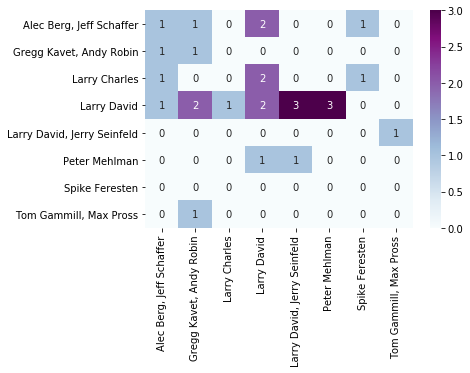

In [331]:
#now running clustering on X_test before adding it as a feature for X_test:

X_doc2vec_test = X_test.drop(columns=['Episode', 'text'])

# Normalize the data.
X_doc2vec_norm_test = normalize(X_doc2vec_test)

#graphical data
X_doc2vec_graph_test = PCA(n_components=2).fit_transform(X_doc2vec_norm_test)

# Calculate predicted values.
y_pred_Kmeans_test = KMeans(n_clusters=4, random_state=42).fit_predict(X_doc2vec_graph_test)

#test cluster dataframe
KMeans_df_test = pd.DataFrame()
KMeans_df_test = X_test.drop(columns=['Episode'])
KMeans_df_test['clusters'] = y_pred_Kmeans_test

#Random Forest Classifier
print('K Means Random Forest Test Group score with clusters:', rfc.score(KMeans_df_test.drop(columns=['text']), Y_test))

wclust = rfc.predict((KMeans_df_test.drop(columns=['text'])))
testlabels = list(set(Y_test[:]))
testlabels = sorted(testlabels)
ax = sns.heatmap(confusion_matrix(wclust, Y_test), cmap='BuPu', annot=True, fmt="d",xticklabels=testlabels,
           yticklabels=testlabels)


## Logistic Regression on KMeans

KMeans Log Test Group score without clusters: 0.2962962962962963


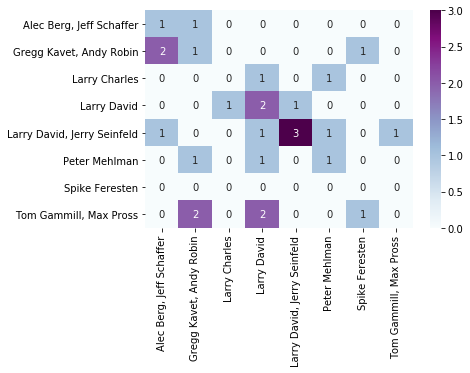

In [332]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
## putting cluster into rfc_xtrain
lr_xtrain = X_train.drop(columns=['clusters', 'text'])
lr_xtrain['clusters'] = KMeans_df['clusters']
lr.fit(lr_xtrain, Y_train)

#rfc model without clusters
lr2 = LogisticRegression()
lr_xtrain_no_clust = X_train.drop(columns=['clusters', 'text'])
lr2.fit(lr_xtrain_no_clust, Y_train)

#plugging Test holdout group without clusters with confusion matrix
print('KMeans Log Test Group score without clusters:', lr2.score(X_test.drop(columns=['Episode', 'text']), Y_test))


#confusion matrix
noclust = lr2.predict(X_test.drop(columns=['Episode', 'text']))
from sklearn.metrics import confusion_matrix
confusion_matrix(noclust, Y_test)
testlabels = list(set(Y_test[:]))
testlabels = sorted(testlabels)
ax = sns.heatmap(confusion_matrix(noclust, Y_test), cmap='BuPu', annot=True, fmt="d",xticklabels=testlabels,
           yticklabels=testlabels )

K Means Log Test Group score with clusters: 0.2962962962962963


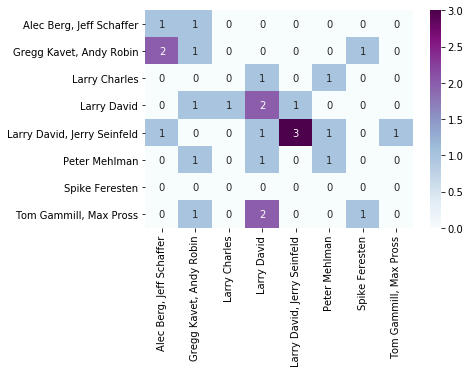

In [333]:
#now running clustering on X_test before adding it as a feature for X_test:

X_doc2vec_test = X_test.drop(columns=['Episode', 'text'])

# Normalize the data.
X_doc2vec_norm_test = normalize(X_doc2vec_test)

#graphical data
X_doc2vec_graph_test = PCA(n_components=2).fit_transform(X_doc2vec_norm_test)

# Calculate predicted values.
y_pred_Kmeans_test = KMeans(n_clusters=4, random_state=42).fit_predict(X_doc2vec_graph_test)

#test cluster dataframe
KMeans_df_test = pd.DataFrame()
KMeans_df_test = X_test.drop(columns=['Episode'])
KMeans_df_test['clusters'] = y_pred_Kmeans_test

#Random Forest Classifier
print('K Means Log Test Group score with clusters:', lr.score(KMeans_df_test.drop(columns=['text']), Y_test))

wclust = lr.predict((KMeans_df_test.drop(columns=['text'])))
testlabels = list(set(Y_test[:]))
testlabels = sorted(testlabels)
ax = sns.heatmap(confusion_matrix(wclust, Y_test), cmap='BuPu', annot=True, fmt="d",xticklabels=testlabels,
           yticklabels=testlabels)

## Log Regression on Spectral clusters:

Spectral Clustering Log Test Group score without clusters: 0.2962962962962963


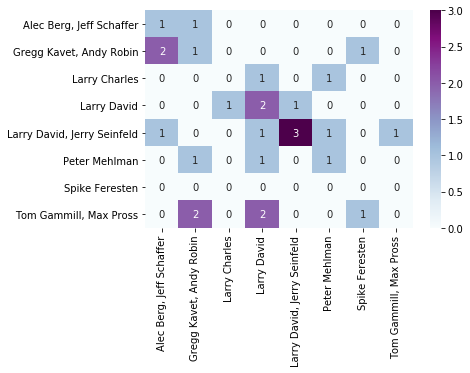

In [334]:
from sklearn.linear_model import LogisticRegression

#setting up Spectral DF
spec_df = pd.DataFrame()
spec_df = X_train
spec_df['clusters'] = y_pred_sc
spec_df['text'] = X_train_w_text['text']


lr = LogisticRegression()
## putting cluster into rfc_xtrain
lr_xtrain = X_train.drop(columns=['clusters', 'text'])
lr_xtrain['clusters'] = spec_df['clusters']
lr.fit(lr_xtrain, Y_train)

#rfc model without clusters
lr2 = LogisticRegression()
lr_xtrain_no_clust = X_train.drop(columns=['clusters', 'text'])
lr2.fit(lr_xtrain_no_clust, Y_train)

#plugging Test holdout group without clusters with confusion matrix
print('Spectral Clustering Log Test Group score without clusters:', lr2.score(X_test.drop(columns=['Episode', 'text']), Y_test))


#confusion matrix
noclust = lr2.predict(X_test.drop(columns=['Episode', 'text']))
from sklearn.metrics import confusion_matrix
confusion_matrix(noclust, Y_test)
testlabels = list(set(Y_test[:]))
testlabels = sorted(testlabels)
ax = sns.heatmap(confusion_matrix(noclust, Y_test), cmap='BuPu', annot=True, fmt="d",xticklabels=testlabels,
           yticklabels=testlabels )

Spectral Clustering Log Test Group score with clusters: 0.2962962962962963


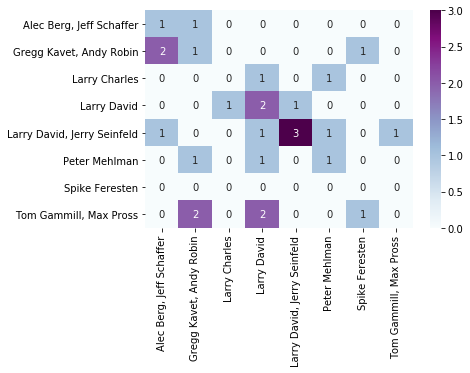

In [335]:
#now running clustering on X_test before adding it as a feature for X_test:

X_doc2vec_test = X_test.drop(columns=['Episode', 'text'])

# Normalize the data.
X_doc2vec_norm_test = normalize(X_doc2vec_test)

#graphical data
X_doc2vec_graph_test = PCA(n_components=2).fit_transform(X_doc2vec_norm_test)

# Calculate predicted values.
y_pred_spec_test = SpectralClustering(n_clusters=4, random_state=42).fit_predict(X_doc2vec_graph_test)

#test cluster dataframe
spec_df_test = pd.DataFrame()
spec_df_test = X_test.drop(columns=['Episode'])
spec_df_test['clusters'] = y_pred_spec_test

#Random Forest Classifier
print('Spectral Clustering Log Test Group score with clusters:', lr.score(spec_df_test.drop(columns=['text']), Y_test))

wclust = lr.predict((KMeans_df_test.drop(columns=['text'])))
testlabels = list(set(Y_test[:]))
testlabels = sorted(testlabels)
ax = sns.heatmap(confusion_matrix(wclust, Y_test), cmap='BuPu', annot=True, fmt="d",xticklabels=testlabels,
           yticklabels=testlabels)

## Trying tfi-df Vectorizer on data:

In [350]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )
#takes raw documents, 


X = tfidf.fit_transform(X_train['text'])
print("Number of features: %d" % X.get_shape()[1])
from sklearn.model_selection import train_test_split
X_train_tfidf, X_test_tfidf= train_test_split(X, test_size=0.25, random_state=0)

Number of features: 5812


In [353]:
X_train_tfidf_csr = X_train_tfidf

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = tfidf.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]


Trying Kmeans on tfidf features:

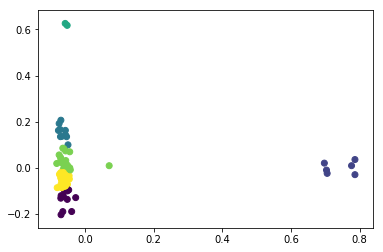

In [352]:
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

# Normalize the data.
X_norm = normalize(X).toarray()

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pred_tfi_k = KMeans(n_clusters=6, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_tfi_k)
plt.show()


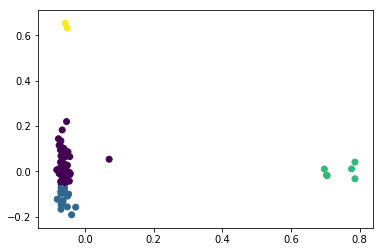

In [265]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=4)

# Calculate predicted values.
y_pred_sc_tf = spectral.fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_sc_tf)
plt.show()

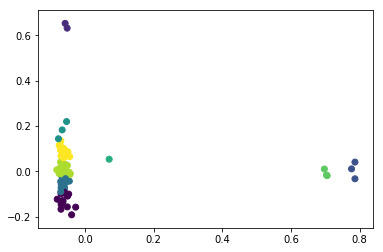

In [266]:
# Calculate predicted values.
y_pred_ap_tfi = AffinityPropagation(damping=0.95, max_iter=1000, convergence_iter=100, ).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_ap_tfi)
plt.show()

In [268]:
## Evaluating clusters from Tfidf:
## Kmeans:

# Silhouette Score:
print('KMeans:', silhouette_score(X_pca, y_pred_tfi_k, metric='cosine'))

# Crosstab
print('Kmeans:', pd.crosstab(y_pred_tfi_k, Y_train))    

# Silhouette Score:
print('Spectral Clustering:', silhouette_score(X_pca, y_pred_sc_tf, metric='cosine'))

# Crosstab
print('Spectral Clustering:', pd.crosstab(y_pred_sc_tf, Y_train))    

# Silhouette Score:
print('Affinity Propagation:', silhouette_score(X_pca, y_pred_ap_tfi, metric='cosine'))

# Crosstab
print('Affinity Propagation:', pd.crosstab(y_pred_ap_tfi, Y_train))    



KMeans: 0.4158412549019036
Kmeans: Writers  Alec Berg, Jeff Schaffer  Gregg Kavet, Andy Robin  Larry Charles  \
row_0                                                                       
0                               1                        4              4   
1                               0                        0              0   
2                               0                        0              2   
3                               0                        0              1   
4                               4                        1              4   
5                               0                        0              3   

Writers  Larry David  Larry David, Jerry Seinfeld  Peter Mehlman  \
row_0                                                              
0                 10                            4              4   
1                  1                            4              1   
2                  0                            0              0   
3       